# Network Topology Selection
<div style="text-align: right">(C) Nikolai Nowaczyk 2019</div>

Choosing a good topology for the neural network is key in order to achieve a successful training as the number of layers and the numbers of unit in each layer directly determine the number of trainable weights. But how to chose the layers and units?

In [13]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib notebook

## Only 1 Layer
Let's first study the relationship between the layers, the units and the number of trainiable weights in a bit more detail: In the easiest case, one only has $n_L = 1$ layers. In that case, the number $n_w$ of trainable weights is given by
$$ n_w = n_o  n_i + n_o,$$
where
* $n_i$ is the number of inputs,
* $n_o$ is the number of outputs.

This is because we need a matrix of shape $n_o x n_i$ and a vector of length $n_o$ for the bias (we always assume that we train the bias).

In particular, for a network with only $n_L = 1$ layer, the topology is completely determined by the input and the output dimensions and there is no choice to be made. 

In [14]:
# in keras, this setup corresponds to
n_o = 3
n_i = 2
model = Sequential([
    Dense(units=n_o, input_shape=(n_i,)),
])
print(n_i*n_o + n_o)
model.summary()

9
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


## 2 Layers
If we allow $n_L=2$ layers, then we have to choose the number $n_u$ of units in the first layer. The resulting number of weights will be
$$ n_w = n_u n_i + n_u + n_o n_u + n_o = n_u(n_i + n_o + 1) + n_o, $$
because for the first layer, we need one matrix of shape $n_u x n_i$ and a vector of shape $n_u$, and for the second layer we need a matrix of shape $n_o x n_u$ and a vector of shape $n_o$. Thus, the only parameter we need to choose is $n_u$. 

In [15]:
# in keras, this setup corresponds to
n_o = 3
n_i = 2
n_u = 10
model = Sequential([
    Dense(units=n_u, input_shape=(n_i,)),
    Dense(units=n_o),
])
print(n_u * (n_i + n_o + 1) + n_o)
model.summary()

63
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 33        
Total params: 63
Trainable params: 63
Non-trainable params: 0
_________________________________________________________________


## Arbitrary many hidden layers
In case the number of layers is $n_L \geq 3$, we have to choose the number of units $n_u$ for all but the last layers separately. If we enumerate the layers from input to output by $1, \ldots, n_L$ and denote by $n_{u_i}$ the number of units in each layer, then the total number of trainable weights is given by
$$ n_w = n_i n_{u_1} + n_{u_1} + n_{u_L} n_o + n_o + \sum_{i=2}^{n_L - 1}{n_{u_{i-1}} n_{u_{i}} +n_{u_i}},$$
which in theory leaves us with many choices. 

If we assume that all but the output layer have the same number of units, i.e. $n_{u_i}=n_u$ for $1 \leq i < N_L$, then we only have to choose one number $n_u$ and the resulting number of trainable weights simplifies to:
$$ n_w = (n_L - 2) n_u^2 + (n_i + n_o + n_L - 1)n_u + n_o ,$$
which requires $2$ choices, namely $n_L$, the number of layers, and $n_u$, the number of units per layer.

In [16]:
# in keras, an example is given by
n_o = 3
n_i = 2
n_u = 10
n_L = 5
model = Sequential([
    Dense(units=n_u, input_shape=(n_i,)),
    Dense(units=n_u),
    Dense(units=n_u),
    Dense(units=n_u),
    Dense(units=n_o),
])
print( (n_L - 2) * n_u**2 + (n_i + n_o + n_L - 1) * n_u + n_o)
model.summary()

393
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_13 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_14 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_15 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 33        
Total params: 393
Trainable params: 393
Non-trainable params: 0
_________________________________________________________________


## Balancing Layers, Units and Weights

We have seen that under the assumption that every layer has the same number of units (except the output layer), the number $n_w$ of trainable weights is a function $n_w = n_w(n_L, w_u)$ of the number $n_L$ of layers and $n_u$ of units per layer.

In order to find a good network topology for a given problem, one could of course simply try out a grid of networks parametrised by $n_L$ and $n_u$. However, if we study this function using some simple examples, we see that this might not be the best choice.

In [17]:
# implement $n_w$ function
def num_weights(n_i, n_o, n_L, n_u):
    """
    Computes the total number of parameters in an MLP assuming all layers have the same
    number of units (except the output layer).

    param n_i: number of inputs
    param n_o: number of outputs
    param n_L: number of layers
    param n_u: number of units per layer

    returns: total number of trainable weights

    """
    if n_L == 2:
        return n_u * (n_i + n_o + 1) + n_o
    else:
        return (n_L - 2) * n_u**2 + (n_i + n_o + n_L - 1) * n_u + n_o

<IPython.core.display.Javascript object>


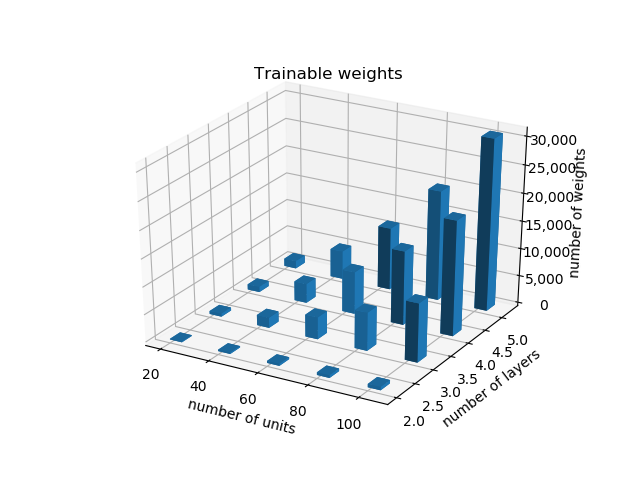

In [18]:
# create example 
n_o = 3
n_i = 2
units = np.arange(20, 120, 20)
layers = np.arange(2, 6)
xx, yy = np.meshgrid(units, layers)
x, y = xx.ravel(), yy.ravel()
z = np.array([[num_weights(n_i, n_o, l, u) for u in units] for l in layers]).ravel()
bottom = np.zeros_like(z)

# plot example
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
width = 5
depth = 0.25
ax.bar3d(x, y, bottom, width, depth, z, shade=True)
ax.set_title('Trainable weights')
ax.set_xlabel('number of units')
ax.set_ylabel('number of layers')
ax.set_zlabel('number of weights')
ax.zaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

As illustrated by the above plot, the degrees of freedom in the network, i.e. the numner $n_w$ of weights, depends linearly on the number $n_L$ of layers, but quadratically on the number $n_u$ of units. This means that doubling the number of layers will double the number of weights, but doubling the number of units will quadruple the number of weights. 

Thus, if we want to find the optimal, or say a ''good'' network topology for a given problem, it is hard to say if it is better to increase the number of units or the number of layers, because these increases have different effects on the number of weights. But ultimately, the number of weights are the degrees of freedom the neural network has to learn the given problem. 

Therefore, it is more insightful to start with a set of candidate numbers for the given units $n_u$ and then increase the number of layers, but keeping the number of weights fixed. This can be achieved by reducing the number of untits after increasing the number of layers. The mathematics of this are governed by rewriting the equation for $n_w$ 

$$ n_w = (n_L - 2) n_u^2 + (n_i + n_o + n_L - 1)n_u + n_o \quad \Longleftrightarrow  \quad  n_u^2 + \underbrace{\frac{n_i + n_o + n_L - 1}{n_L - 2}}_{=:p} n_u + \underbrace{\frac{n_o - n_w}{n_L - 2}}_{=:q} = 0
$$

and solving this quadratic equation for $n_u$. The positive solution is thus given by
$$ n_u = - \frac{p}{2} + \sqrt{\frac{p^2}{4} - q} $$

Using this we can keep the number of weights constant when increasing the number of layers. We illustrate this with an example.

In [19]:
# implement $n_u$  as function of $n_w$
def num_units(n_i, n_o, n_L, n_w):
    """
    Computes the total number ofunits per layer to achieve a given number of parameters assuming all layers 
    have the same number of units (except the output layer).

    param n_i: number of inputs
    param n_o: number of outputs
    param n_L: number of weights    
    param n_w: number of weights

    returns: number of units per layer needed

    """
    if n_L == 2:
        return int((n_w -  n_o) /(n_i + n_o + 1))
    else:
        p = n_i + n_o + n_L - 1
        p /= n_L - 2
        q = n_o - n_w
        q /= n_L - 2
        return int(-p/2 + np.sqrt(p**2/4 - q))

<IPython.core.display.Javascript object>


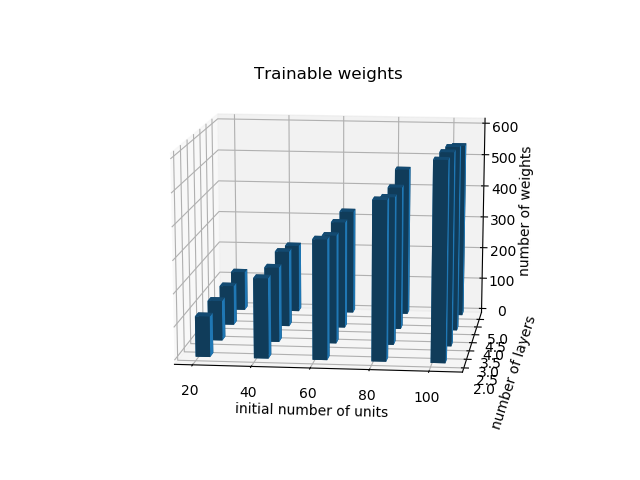

In [20]:
# create example 
n_o = 3
n_i = 2
layers = np.arange(2, 6)
units = np.arange(20, 120, 20)
weights ={u : num_weights(n_i, n_o, layers[0], u) for u in units}
xx, yy = np.meshgrid(units, layers)
x, y = xx.ravel(), yy.ravel()
z = np.array([[num_weights(n_i, n_o, l, num_units(n_i, n_o, l, weights[u])) for u in units] for l in layers]).ravel()

# plot example
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
width = 5
depth = 0.25
ax.bar3d(x, y, bottom, width, depth, z, shade=True)
ax.set_title('Trainable weights')
ax.set_xlabel('initial number of units')
ax.set_ylabel('number of layers')
ax.set_zlabel('number of weights')
ax.zaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

We see that the numer of weights now increases linearly with the number of units, but stays roughly constant with the number of layers (because the number of units is decreased). It does not stay exactly constant due to rounding the solution of the quadratic equation.

## Synopsis

This leaves us with the following method of determining a good network topology for any given problem:

* Increase the number $n_u$ of units acroos a certain range and obtain an initial range of trainable weights
* For any given initial number of units, increase the number $n_L$ of layers across a certain range keeping the the degrees of freedom, i.e. the number $n_w$ of trainable weights, constant.

This allows a more meaningful comparison between various network topologies.